In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping

In [65]:
"""
Returns the tau's to be predicted
"""
def get_output_data(prefix):
    tau_11 = loadmat(prefix + 'tau11_xyz_T1.mat')['tau11']
    tau_12 = loadmat(prefix + 'tau12_xyz_T1.mat')['tau12']
    tau_13 = loadmat(prefix + 'tau13_xyz_T1.mat')['tau13']
    tau_22 = loadmat(prefix + 'tau22_xyz_T1.mat')['tau22']
    tau_23 = loadmat(prefix + 'tau23_xyz_T1.mat')['tau23']
    tau_33 = loadmat(prefix + 'tau33_xyz_T1.mat')['tau33']
    
    tau_11 = np.pad(tau_11, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_12 = np.pad(tau_12, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_13 = np.pad(tau_13, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_22 = np.pad(tau_22, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_23 = np.pad(tau_23, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_33 = np.pad(tau_33, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    
    return tau_11, tau_12, tau_13, tau_22, tau_23, tau_33

In [4]:
"""
Returns the heat's to be predicted
"""
def get_output_data_heat(prefix):
    heat_1 = loadmat(prefix + 'Heat1_xyz_T1.mat')['Heat1']
    heat_2 = loadmat(prefix + 'Heat2_xyz_T1.mat')['Heat2']
    heat_3 = loadmat(prefix + 'Heat3_xyz_T1.mat')['Heat3']
    return heat_1, heat_2, heat_3

In [66]:
"""
Returns the tau's to be predicted
"""
def get_input_data(prefix):
    uf = loadmat(prefix + 'u_F_xyz_T1.mat')['u_F']
    vf = loadmat(prefix + 'v_F_xyz_T1.mat')['v_F']
    wf = loadmat(prefix + 'w_F_xyz_T1.mat')['w_F']
    tke = loadmat(prefix + 'TKE_F_xyz_T1.mat')['TKE_F']
    theta = loadmat(prefix + 'TKE_F_xyz_T1.mat')['TKE_F']
    grad = loadmat(prefix + 'TKE_F_xyz_T1.mat')['TKE_F']
    
    uf = np.pad(uf, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    vf = np.pad(vf, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    wf = np.pad(wf, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tke = np.pad(tke, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    theta = np.pad(theta, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    grad = np.pad(grad, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    return uf, vf, wf, tke, theta, grad

In [6]:
"""
Returns the tau's to be predicted
"""
def get_input_data_heat(prefix):
    uf = loadmat(prefix + 'u_F_xyz_T1.mat')['u_F']
    vf = loadmat(prefix + 'v_F_xyz_T1.mat')['v_F']
    wf = loadmat(prefix + 'w_F_xyz_T1.mat')['w_F']
    theta = loadmat(prefix + 'theta_F_xyz_T1.mat')['theta_F']
    grad = loadmat(prefix + 'grad_Tz_F_xyz_T1.mat')['grad_T_z']
    return uf, vf, wf, theta, grad

In [7]:
"""
Explores Dataset
"""
def explore_data(data):
    plt.figure(figsize=(15,5))
    # Varying by X
    plt.subplot(1,3,1)
    plt.plot(data[:,0,0])
    # Varying by Y
    plt.subplot(1,3,2)
    plt.plot(data[0,:,0])
    # Varying by Z
    plt.subplot(1,3,3)
    plt.plot(data[0,0,:])
    plt.show()

In [8]:
"""
Denormalizes Outputs
"""
def denormalize_data(train, test):
    mu, std = np.mean(train.flatten()), np.std(train.flatten())
    train_new = (train - mu)/std
    test_new = (test - mu)/std
    print()
    return train_new, test_new, mu, std

In [9]:
"""
Denormalizes Outputs
"""
def denormalize_data_feng(train, valid, test):
    mu, std = np.mean(train.flatten()), np.std(train.flatten())
    train_new = (train - mu)/std
    valid_new = (valid - mu)/std
    test_new = (test - mu)/std
    print()
    return train_new, valid_new, test_new, mu, std

In [10]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                           uf, vf, wf, tke, theta, grad,
                           train_pct, size = 1, augmentation = None):
    
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten(), tke.flatten(),
                                       theta.flatten(), grad.flatten()]))
    
    tau_11_dataset = np.transpose(np.array([tau_11.flatten()]))
    tau_12_dataset = np.transpose(np.array([tau_12.flatten()]))
    tau_13_dataset = np.transpose(np.array([tau_13.flatten()]))
    tau_22_dataset = np.transpose(np.array([tau_22.flatten()]))
    tau_23_dataset = np.transpose(np.array([tau_23.flatten()]))
    tau_33_dataset = np.transpose(np.array([tau_33.flatten()]))

    print(x_dataset.shape)
    print(tau_11_dataset.shape, tau_12_dataset.shape, tau_13_dataset.shape,
          tau_22_dataset.shape, tau_23_dataset.shape, tau_33_dataset.shape)

    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]
    x_normalized = [denormalize_data(x_train[:,k], x_test[:,k]) for k in range(x_train.shape[1])]
    x_train = np.transpose(np.array([k[0] for k in x_normalized]))
    x_test = np.transpose(np.array([k[1] for k in x_normalized]))
    
    print(x_train.shape)
    print(x_test.shape)

    tau_11_train, tau_11_test = tau_11_dataset[train_test_index,:], tau_11_dataset[~train_test_index,:]
    tau_12_train, tau_12_test = tau_12_dataset[train_test_index,:], tau_12_dataset[~train_test_index,:]
    tau_13_train, tau_13_test = tau_13_dataset[train_test_index,:], tau_13_dataset[~train_test_index,:]
    tau_22_train, tau_22_test = tau_22_dataset[train_test_index,:], tau_22_dataset[~train_test_index,:]
    tau_23_train, tau_23_test = tau_23_dataset[train_test_index,:], tau_23_dataset[~train_test_index,:]
    tau_33_train, tau_33_test = tau_33_dataset[train_test_index,:], tau_33_dataset[~train_test_index,:]
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [11]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets_heat(heat_1, heat_2, heat_3,
                                uf, vf, wf, theta, grad,
                                train_pct, size = 1, augmentation = None):
    
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten(), theta.flatten(), grad.flatten()]))
    
    heat_1_dataset = np.transpose(np.array([heat_1.flatten()]))
    heat_2_dataset = np.transpose(np.array([heat_2.flatten()]))
    heat_3_dataset = np.transpose(np.array([heat_3.flatten()]))

    print(x_dataset.shape)
    print(heat_1_dataset.shape, heat_2_dataset.shape, heat_3_dataset.shape)
    
    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]
    x_normalized = [denormalize_data(x_train[:,k], x_test[:,k]) for k in range(x_train.shape[1])]
    x_train = np.transpose(np.array([k[0] for k in x_normalized]))
    x_test = np.transpose(np.array([k[1] for k in x_normalized]))
    
    print(x_train.shape)
    print(x_test.shape)

    heat_1_train, heat_1_test = heat_1_dataset[train_test_index,:], heat_1_dataset[~train_test_index,:]
    heat_2_train, heat_2_test = heat_2_dataset[train_test_index,:], heat_2_dataset[~train_test_index,:]
    heat_3_train, heat_3_test = heat_3_dataset[train_test_index,:], heat_3_dataset[~train_test_index,:]
    
    heat_1_train, heat_1_test, mu_1, std_1 = denormalize_data(heat_1_train, heat_1_test)
    heat_2_train, heat_2_test, mu_2, std_2 = denormalize_data(heat_2_train, heat_2_test)
    heat_3_train, heat_3_test, mu_3, std_3 = denormalize_data(heat_3_train, heat_3_test)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, heat_1_train, heat_1_test, heat_2_train, heat_2_test,
            heat_3_train, heat_3_test,
            mu_1, std_1, mu_2, std_2, mu_3, std_3)

In [48]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                           uf, vf, wf, tke, theta, grad,
                                           train_pct, size = 3, augmentation = None):
    
    train_index = np.concatenate((np.ones((uf.shape[0], uf.shape[1], int(np.floor(uf.shape[0]*0.75))), dtype = 'bool'),
                           np.zeros((uf.shape[0], uf.shape[1], int(np.ceil(uf.shape[0]*(1-0.75)))), dtype = 'bool')),
                           axis = 2)
    
    print(train_index.shape)
    
    test_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*1)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-1))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    tau_11_train, tau_11_test = np.transpose([tau_11[train_locs]]), np.transpose([tau_11[test_locs]])
    tau_12_train, tau_12_test = np.transpose([tau_12[train_locs]]), np.transpose([tau_12[test_locs]])
    tau_13_train, tau_13_test = np.transpose([tau_13[train_locs]]), np.transpose([tau_13[test_locs]])
    tau_22_train, tau_22_test = np.transpose([tau_22[train_locs]]), np.transpose([tau_22[test_locs]])
    tau_23_train, tau_23_test = np.transpose([tau_23[train_locs]]), np.transpose([tau_23[test_locs]])
    tau_33_train, tau_33_test = np.transpose([tau_33[train_locs]]), np.transpose([tau_33[test_locs]])
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    if augmentation:
        axes = ((0,1),(0,2),(1,2))
        
        rotations_train = np.random.randint(0, 4, size = (x_train.shape[0], 3))
        axes_train = np.random.randint(0, 3, size = (x_train.shape[0], 3))
        x_train_new = np.array([np.stack([np.rot90(x_train[i,:,:,:,0], rotations_train[i,0], axes[axes_train[i,0]]),
                                          np.rot90(x_train[i,:,:,:,1], rotations_train[i,1], axes[axes_train[i,1]]),
                                          np.rot90(x_train[i,:,:,:,2], rotations_train[i,2], axes[axes_train[i,2]]),
                                          x_train[i,:,:,:,3]],
                                        axis = 3)
                                for i in range(x_train.shape[0])])
        print(x_train_new.shape)
        
        x_train = np.concatenate([x_train, x_train_new], axis = 0)
        
        tau_11_train = np.tile(tau_11_train, (2,1))
        tau_12_train = np.tile(tau_12_train, (2,1))
        tau_13_train = np.tile(tau_13_train, (2,1))
        tau_22_train = np.tile(tau_22_train, (2,1))
        tau_23_train = np.tile(tau_23_train, (2,1))
        tau_33_train = np.tile(tau_33_train, (2,1))
        
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [55]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d_multiple(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                           uf, vf, wf, tke, theta, grad,
                                           train_pct, size = 3, augmentation = None):
    
    train_index = np.concatenate((np.ones((uf.shape[0], uf.shape[1], int(np.floor(uf.shape[2]*0.75))), dtype = 'bool'),
                           np.zeros((uf.shape[0], uf.shape[1], int(np.ceil(uf.shape[2]*(1-0.75)))), dtype = 'bool')),
                           axis = 2)
    
    print(train_index.shape)
    
    test_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*1)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-1))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    tau_11_train, tau_11_test = np.transpose([tau_11[train_locs]]), np.transpose([tau_11[test_locs]])
    tau_12_train, tau_12_test = np.transpose([tau_12[train_locs]]), np.transpose([tau_12[test_locs]])
    tau_13_train, tau_13_test = np.transpose([tau_13[train_locs]]), np.transpose([tau_13[test_locs]])
    tau_22_train, tau_22_test = np.transpose([tau_22[train_locs]]), np.transpose([tau_22[test_locs]])
    tau_23_train, tau_23_test = np.transpose([tau_23[train_locs]]), np.transpose([tau_23[test_locs]])
    tau_33_train, tau_33_test = np.transpose([tau_33[train_locs]]), np.transpose([tau_33[test_locs]])
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])        
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test)

In [13]:
"""
Reshapes Data and split data into train, validation and test sets (Convolutional & Feng Set up)
"""
def create_train_test_sets_conv3d_feng(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                       uf, vf, wf, tke, theta, grad,
                                       train_pct, size = 3, augmentation = None):
    
    train_index = np.concatenate((np.zeros((uf.shape[0], 32, uf.shape[2]), dtype = 'bool'),
                                  np.ones((uf.shape[0], 64, uf.shape[2]), dtype = 'bool')),
                                  axis = 1)
    valid_index = np.concatenate((np.ones((uf.shape[0], 16, uf.shape[2]), dtype = 'bool'),
                                  np.zeros((uf.shape[0], 80, uf.shape[2]), dtype = 'bool')),
                                  axis = 1)
    test_index = np.concatenate((np.zeros((uf.shape[0], 16, uf.shape[2]), dtype = 'bool'),
                                 np.ones((uf.shape[0], 16, uf.shape[2]), dtype = 'bool'),
                                 np.zeros((uf.shape[0], 64, uf.shape[2]), dtype = 'bool')),
                                 axis = 1)
    
    print(train_index.shape)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    valid_index[0:(0+offset_size),:,:] = False
    valid_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    valid_index[:,0:(0+offset_size),:] = False
    valid_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    valid_index[:,:,0:(0+offset_size)] = False
    valid_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    valid_locs = np.where(valid_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    tau_11_train, tau_11_valid, tau_11_test = np.transpose([tau_11[train_locs]]), np.transpose([tau_11[valid_locs]]), np.transpose([tau_11[test_locs]])
    tau_12_train, tau_12_valid, tau_12_test = np.transpose([tau_12[train_locs]]), np.transpose([tau_12[valid_locs]]), np.transpose([tau_12[test_locs]])
    tau_13_train, tau_13_valid, tau_13_test = np.transpose([tau_13[train_locs]]), np.transpose([tau_13[valid_locs]]), np.transpose([tau_13[test_locs]])
    tau_22_train, tau_22_valid, tau_22_test = np.transpose([tau_22[train_locs]]), np.transpose([tau_22[valid_locs]]), np.transpose([tau_22[test_locs]])
    tau_23_train, tau_23_valid, tau_23_test = np.transpose([tau_23[train_locs]]), np.transpose([tau_23[valid_locs]]), np.transpose([tau_23[test_locs]])
    tau_33_train, tau_33_valid, tau_33_test = np.transpose([tau_33[train_locs]]), np.transpose([tau_33[valid_locs]]), np.transpose([tau_33[test_locs]])
    
    tau_11_train, tau_11_valid, tau_11_test, mu_11, std_11 = denormalize_data_feng(tau_11_train, tau_11_valid, tau_11_test)
    tau_12_train, tau_12_valid, tau_12_test, mu_12, std_12 = denormalize_data_feng(tau_12_train, tau_12_valid, tau_12_test)
    tau_13_train, tau_13_valid, tau_13_test, mu_13, std_13 = denormalize_data_feng(tau_13_train, tau_13_valid, tau_13_test)
    tau_22_train, tau_22_valid, tau_22_test, mu_22, std_22 = denormalize_data_feng(tau_22_train, tau_22_valid, tau_22_test)
    tau_23_train, tau_23_valid, tau_23_test, mu_23, std_23 = denormalize_data_feng(tau_23_train, tau_23_valid, tau_23_test)
    tau_33_train, tau_33_valid, tau_33_test, mu_33, std_33 = denormalize_data_feng(tau_33_train, tau_33_valid, tau_33_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])
    
    x_valid = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(valid_locs[0], valid_locs[1], valid_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    x_normalized = [denormalize_data_feng(x_train[:,:,:,:,k], x_valid[:,:,:,:,k], x_test[:,:,:,:,k]) 
                    for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_valid = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[2] for k in x_normalized], axis = 4)) 
          
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_valid, x_test, tau_11_train, tau_11_valid, tau_11_test, 
            tau_12_train, tau_12_valid, tau_12_test, tau_13_train, tau_13_valid, tau_13_test,
           tau_22_train, tau_22_valid, tau_22_test, tau_23_train, tau_23_valid, tau_23_test, 
            tau_33_train, tau_33_valid, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [14]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d_heat(heat_1, heat_2, heat_3,
                                       uf, vf, wf, theta, grad,
                                       train_pct, size = 3, augmentation = None):
    
    train_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*train_pct)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-train_pct))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    print(train_index.shape)
    
    test_index = (train_index)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    heat_1_train, heat_1_test = np.transpose([heat_1[train_locs]]), np.transpose([heat_1[test_locs]])
    heat_2_train, heat_2_test = np.transpose([heat_2[train_locs]]), np.transpose([heat_2[test_locs]])
    heat_3_train, heat_3_test = np.transpose([heat_3[train_locs]]), np.transpose([heat_3[test_locs]])
    
    heat_1_train, heat_1_test, mu_1, std_1 = denormalize_data(heat_1_train, heat_1_test)
    heat_2_train, heat_2_test, mu_2, std_2 = denormalize_data(heat_2_train, heat_2_test)
    heat_3_train, heat_3_test, mu_3, std_3 = denormalize_data(heat_3_train, heat_3_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                 grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    print(x_test.shape)
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    if augmentation == 'rotate':
        axes = ((0,1),(0,2),(1,2))
        
        rotations_train = np.random.randint(0, 4, size = (x_train.shape[0], 3))
        axes_train = np.random.randint(0, 3, size = (x_train.shape[0], 3))
        x_train_new = np.array([np.stack([np.rot90(x_train[i,:,:,:,0], rotations_train[i,0], axes[axes_train[i,0]]),
                                          np.rot90(x_train[i,:,:,:,1], rotations_train[i,1], axes[axes_train[i,1]]),
                                          np.rot90(x_train[i,:,:,:,2], rotations_train[i,2], axes[axes_train[i,2]]),
                                          x_train[i,:,:,:,3],
                                          x_train[i,:,:,:,4]],
                                        axis = 3)
                                for i in range(x_train.shape[0])])
        print(x_train_new.shape)
        
        x_train = np.concatenate([x_train, x_train_new], axis = 0)
        
        heat_1_train = np.tile(heat_1_train, (2,1))
        heat_2_train = np.tile(heat_2_train, (2,1))
        heat_3_train = np.tile(heat_3_train, (2,1))
        
    elif augmentation == 'reflect':
        
        reflect_train = np.random.randint(0, 3, size = (x_train.shape[0], 3))
        x_train_new = np.array([np.stack([np.flip(x_train[i,:,:,:,0], axis = reflect_train[i,0]),
                                          np.flip(x_train[i,:,:,:,1], axis = reflect_train[i,1]),
                                          np.flip(x_train[i,:,:,:,2], axes = reflect_train[i,2]),
                                          x_train[i,:,:,:,3],
                                          x_train[i,:,:,:,4]],
                                        axis = 3)
                                for i in range(x_train.shape[0])])
        print(x_train_new.shape)
        
        x_train = np.concatenate([x_train, x_train_new], axis = 0)
        
        heat_1_train = np.tile(heat_1_train, (2,1))
        heat_2_train = np.tile(heat_2_train, (2,1))
        heat_3_train = np.tile(heat_3_train, (2,1))

        
    print('X_train shape', x_train.shape)
    print('tau_train shape', heat_1_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, heat_1_train, heat_1_test, heat_2_train, heat_2_test, heat_3_train, heat_3_test,
            mu_1, std_1, mu_2, std_2, mu_3, std_3)

In [15]:
"""
Trains Simple One-Layer Neural Network with Relu Activation Functions
"""
def train_simple_nn_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                          batch_size = 1024, epochs = 20, num_nodes = 10, xdim = 3, size = 1):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
    
    model = Sequential()
    model.add(Dense(num_nodes, activation=act_func, input_shape=(xdim,)))
    model.add(Dense(1, activation=final_act_func))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=[metrics.mse])

    history = model.fit(x_train[:,:xdim], y_train[:,:xdim],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test[:,:xdim], y_test[:,:xdim]))
    score = model.evaluate(x_test[:,:xdim], y_test[:,:xdim], verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [16]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_two_layer_nn_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                             batch_size = 1024, epochs = 20, num_nodes = (10,10), xdim = 3, size = 1):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    model.add(Dense(num_nodes[0], activation=act_func, input_shape=(xdim,)))
    model.add(Dense(num_nodes[1], activation=act_func))
    model.add(Dense(1, activation=final_act_func))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train[:,:xdim], y_train[:,:xdim],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test[:,:xdim], y_test[:,:xdim]))
    score = model.evaluate(x_test[:,:xdim], y_test[:,:xdim], verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [90]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_conv_3d_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                        batch_size = 1024, epochs = 20, num_nodes = 6, xdim = 3, size = 3,
                        sample_weight = None):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    
    model.add(Conv3D(128, kernel_size = (size,size,size), data_format = 'channels_last',
                         input_shape = x_train[...,:xdim].shape[1:], kernel_initializer = 'random_uniform'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = final_act_func))
    

    model.summary()

    model.compile(loss='mse',
                  optimizer=SGD(),
                  metrics=[metrics.mse])
    
    callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')]
                
    history = model.fit(x_train[...,:xdim], y_train[...,:xdim],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_train[...,:xdim], y_train[...,:xdim], sample_weight),
                        sample_weight = sample_weight,
                        callbacks = callback)
    
    score = model.evaluate(x_test[...,:xdim], y_test[...,:xdim], verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [18]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_conv_3d_model_feng(x_train, x_valid, x_test, y_train, y_valid, y_test, act_func = 'tanh',
                          batch_size = 1024, epochs = 20, num_nodes = 6, xdim = 3, size = 3):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    
    model.add(Conv3D(128, kernel_size = (size,size,size), data_format = 'channels_last',
                         input_shape = x_train[...,:xdim].shape[1:], kernel_initializer = 'random_uniform'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = final_act_func))
    

    model.summary()

    model.compile(loss='mse',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train[...,:xdim], y_train[...,:xdim],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_valid[...,:xdim], y_valid[...,:xdim]))
    score = model.evaluate(x_test[...,:xdim], y_test[...,:xdim], verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [19]:
"""
Plots Actual vs. Predicted Values from Model
"""
def visualize(model, x_test, y_test, mu, std):
    y_predict = model.predict(x_test)
    sample_index = (np.random.rand(y_test.shape[0]) < 1000./y_test.shape[0])
    plt.figure(figsize=(15,5))
    plt.plot(y_test[sample_index]*std+mu)
    plt.plot(y_predict[sample_index]*std+mu)
    plt.show()

In [91]:
models = {'one-layer NN': (create_train_test_sets, train_simple_nn_model),
          'two-layer NN': (create_train_test_sets, train_two_layer_nn_model),
          'conv-3d NN': (create_train_test_sets_conv3d, train_conv_3d_model),
          'conv-3d NN Feng': (create_train_test_sets_conv3d_feng, train_conv_3d_model_feng),
          'conv-3d NN Combined': (create_train_test_sets_conv3d_multiple, train_conv_3d_model)}

In [21]:
models_heat = {'one-layer NN': (create_train_test_sets_heat, train_simple_nn_model),
               'two-layer NN': (create_train_test_sets_heat, train_two_layer_nn_model),
               'conv-3d NN': (create_train_test_sets_conv3d_heat, train_conv_3d_model)}

In [22]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict(model, x_test, y_test, mu, std):
    y_test = y_test.flatten()*std + mu
    y_predict = model.predict(x_test).flatten()*std + mu
    return np.corrcoef(y_test, y_predict), np.sqrt(((y_test - y_predict) ** 2).mean())

In [110]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict_multiple(model, x_test, y_test, mu, std, delta):
    y_test = np.multiply(y_test.flatten()*std + mu, delta)
    y_predict = np.multiply(model.predict(x_test).flatten()*std + mu, delta)
    return np.corrcoef(y_test, y_predict), np.sqrt(((y_test - y_predict) ** 2).mean())

In [45]:
"""
Main Function to Execute Model
"""
def main(model_name, size = 1, augmentation = None, xdim = 6,  prefix = '', train_pct = 0.5):
    
    # Output Data
    tau_11, tau_12, tau_13, tau_22, tau_23, tau_33 = get_output_data(prefix)
    print('Shape of Output Files:')
    print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)
    
    # Input Data
    uf, vf, wf, tke, theta, grad = get_input_data(prefix)
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, tau_11_train, tau_11_test, 
     tau_12_train, tau_12_test, tau_13_train, tau_13_test,
     tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
     mu_11, std_11, mu_12, std_12, mu_13, std_13, 
     mu_22, std_22, mu_23, std_23, mu_33, std_33) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                       tau_33, uf, vf, wf, tke, theta, grad,
                                                                          train_pct = train_pct, size = size,
                                                                         augmentation = augmentation)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, tau_11_train, tau_11_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, tau_12_train, tau_12_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, tau_13_train, tau_13_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, tau_22_train, tau_22_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, tau_23_train, tau_23_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, tau_33_train, tau_33_test, 
                               act_func = 'relu', size = size, xdim = xdim)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11),
               predict(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12),
               predict(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13),
               predict(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22),
               predict(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23),
               predict(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)]
    
    visualize(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11)
    visualize(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12)
    visualize(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13)
    visualize(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22)
    visualize(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23)
    visualize(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)
    
    return models_final, results
    

In [92]:
"""
Main Function to Execute Model
"""
def main_multiple(model_name, size = 1, augmentation = None, xdim = 6,  prefix = '', train_pct = 0.5):
    
    # Output Data
    tau_11_08, tau_12_08, tau_13_08, tau_22_08, tau_23_08, tau_33_08 = get_output_data('Re15sh20_DNScoarse8/')
    tau_11_16, tau_12_16, tau_13_16, tau_22_16, tau_23_16, tau_33_16 = get_output_data('Re15sh20_DNScoarse16/')
    tau_11_24, tau_12_24, tau_13_24, tau_22_24, tau_23_24, tau_33_24 = get_output_data('Re15sh20_DNScoarse24/')
    
    # Input Data
    uf_08, vf_08, wf_08, tke_08, theta_08, grad_08 = get_input_data('Re15sh20_DNScoarse8/')
    uf_16, vf_16, wf_16, tke_16, theta_16, grad_16 = get_input_data('Re15sh20_DNScoarse16/')
    uf_24, vf_24, wf_24, tke_24, theta_24, grad_24 = get_input_data('Re15sh20_DNScoarse24/')
    
    print('Shape of Input Files:')
    print(wf.shape)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train_08, x_test_08, tau_11_train_08, tau_11_test_08, 
     tau_12_train_08, tau_12_test_08, tau_13_train_08, tau_13_test_08,
     tau_22_train_08, tau_22_test_08, tau_23_train_08, tau_23_test_08, 
     tau_33_train_08, tau_33_test_08) = train_test_split_func(tau_11_08, tau_12_08, tau_13_08, tau_22_08, tau_23_08, 
                                                        tau_33_08, uf_08, vf_08, wf_08, tke_08, theta_08, grad_08,
                                                        train_pct = train_pct, size = size,
                                                        augmentation = augmentation)
    
    (x_train_16, x_test_16, tau_11_train_16, tau_11_test_16, 
     tau_12_train_16, tau_12_test_16, tau_13_train_16, tau_13_test_16,
     tau_22_train_16, tau_22_test_16, tau_23_train_16, tau_23_test_16, 
     tau_33_train_16, tau_33_test_16) = train_test_split_func(tau_11_16, tau_12_16, tau_13_16, tau_22_16, tau_23_16, 
                                                        tau_33_16, uf_16, vf_16, wf_16, tke_16, theta_16, grad_16,
                                                        train_pct = train_pct, size = size,
                                                        augmentation = augmentation)
    
    (x_train_24, x_test_24, tau_11_train_24, tau_11_test_24, 
     tau_12_train_24, tau_12_test_24, tau_13_train_24, tau_13_test_24,
     tau_22_train_24, tau_22_test_24, tau_23_train_24, tau_23_test_24, 
     tau_33_train_24, tau_33_test_24) = train_test_split_func(tau_11_24, tau_12_24, tau_13_24, tau_22_24, tau_23_24, 
                                                        tau_33_24, uf_24, vf_24, wf_24, tke_24, theta_24, grad_24,
                                                        train_pct = train_pct, size = size,
                                                        augmentation = augmentation)
    
    #x_train_08[:,:,:,:,3] = 0.0379**2
    #x_train_16[:,:,:,:,3] = 0.0758**2
    #x_train_24[:,:,:,:,3] = 0.1138**2
    x_train = np.concatenate([x_train_08, x_train_16, x_train_24], axis = 0)
    print(x_train.shape)
    
    #x_test_08[:,:,:,:,3] = 0.0379**2
    #x_test_16[:,:,:,:,3] = 0.0758**2
    #x_test_24[:,:,:,:,3] = 0.1138**2
    x_test = np.concatenate([x_test_08, x_test_16, x_test_24], axis = 0)
    print(x_test.shape)
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    delta_08, delta_16, delta_24 = 0.0379**2, 0.0758**2, 0.1138**2
    
    tau_11_train_08, tau_12_train_08, tau_13_train_08, \
    tau_22_train_08, tau_23_train_08, tau_33_train_08 = tau_11_train_08/delta_08, tau_12_train_08/delta_08, \
    tau_13_train_08/delta_08, tau_22_train_08/delta_08, tau_23_train_08/delta_08, tau_33_train_08/delta_08
    
    tau_11_train_16, tau_12_train_16, tau_13_train_16, \
    tau_22_train_16, tau_23_train_16, tau_33_train_16 = tau_11_train_16/delta_16, tau_12_train_16/delta_16, \
    tau_13_train_16/delta_16, tau_22_train_16/delta_16, tau_23_train_16/delta_16, tau_33_train_16/delta_16
    
    tau_11_train_24, tau_12_train_24, tau_13_train_24, \
    tau_22_train_24, tau_23_train_24, tau_33_train_24 = tau_11_train_24/delta_24, tau_12_train_24/delta_24, \
    tau_13_train_24/delta_24, tau_22_train_24/delta_24, tau_23_train_24/delta_24, tau_33_train_24/delta_24
    
    tau_11_train = np.concatenate([tau_11_train_08, tau_11_train_16, tau_11_train_24], axis = 0)
    tau_12_train = np.concatenate([tau_12_train_08, tau_12_train_16, tau_12_train_24], axis = 0)
    tau_13_train = np.concatenate([tau_13_train_08, tau_13_train_16, tau_13_train_24], axis = 0)
    tau_22_train = np.concatenate([tau_22_train_08, tau_22_train_16, tau_22_train_24], axis = 0)
    tau_23_train = np.concatenate([tau_23_train_08, tau_23_train_16, tau_23_train_24], axis = 0)
    tau_33_train = np.concatenate([tau_33_train_08, tau_33_train_16, tau_33_train_24], axis = 0)
    
    tau_11_test_08, tau_12_test_08, tau_13_test_08, \
    tau_22_test_08, tau_23_test_08, tau_33_test_08 = tau_11_test_08/delta_08, tau_12_test_08/delta_08, \
    tau_13_test_08/delta_08, tau_22_test_08/delta_08, tau_23_test_08/delta_08, tau_33_test_08/delta_08
    
    tau_11_test_16, tau_12_test_16, tau_13_test_16, \
    tau_22_test_16, tau_23_test_16, tau_33_test_16 = tau_11_test_16/delta_16, tau_12_test_16/delta_16, \
    tau_13_test_16/delta_16, tau_22_test_16/delta_16, tau_23_test_16/delta_16, tau_33_test_16/delta_16
    
    tau_11_test_24, tau_12_test_24, tau_13_test_24, \
    tau_22_test_24, tau_23_test_24, tau_33_test_24 = tau_11_test_24/delta_24, tau_12_test_24/delta_24, \
    tau_13_test_24/delta_24, tau_22_test_24/delta_24, tau_23_test_24/delta_24, tau_33_test_24/delta_24
    
    tau_11_test = np.concatenate([tau_11_test_08, tau_11_test_16, tau_11_test_24], axis = 0)
    tau_12_test = np.concatenate([tau_12_test_08, tau_12_test_16, tau_12_test_24], axis = 0)
    tau_13_test = np.concatenate([tau_13_test_08, tau_13_test_16, tau_13_test_24], axis = 0)
    tau_22_test = np.concatenate([tau_22_test_08, tau_22_test_16, tau_22_test_24], axis = 0)
    tau_23_test = np.concatenate([tau_23_test_08, tau_23_test_16, tau_23_test_24], axis = 0)
    tau_33_test = np.concatenate([tau_33_test_08, tau_33_test_16, tau_33_test_24], axis = 0)
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)
    
    sample_weight = None#np.array([0.01]*tau_11_train_08.shape[0] + 
                     #        [0.08]*tau_11_train_16.shape[0] + 
                     #        [0.64]*tau_11_train_24.shape[0])
    
    #print(sample_weight.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, tau_11_train, tau_11_test, 
                               act_func = 'relu', size = size, xdim = xdim, sample_weight = sample_weight),
                    model_func(x_train, x_test, tau_12_train, tau_12_test, 
                               act_func = 'relu', size = size, xdim = xdim, sample_weight = sample_weight),
                    model_func(x_train, x_test, tau_13_train, tau_13_test, 
                               act_func = 'relu', size = size, xdim = xdim, sample_weight = sample_weight),
                    model_func(x_train, x_test, tau_22_train, tau_22_test, 
                               act_func = 'relu', size = size, xdim = xdim, sample_weight = sample_weight),
                    model_func(x_train, x_test, tau_23_train, tau_23_test, 
                               act_func = 'relu', size = size, xdim = xdim, sample_weight = sample_weight),
                    model_func(x_train, x_test, tau_33_train, tau_33_test, 
                               act_func = 'relu', size = size, xdim = xdim, sample_weight = sample_weight)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11),
               predict(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12),
               predict(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13),
               predict(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22),
               predict(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23),
               predict(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)]
    
    visualize(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11)
    visualize(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12)
    visualize(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13)
    visualize(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22)
    visualize(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23)
    visualize(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)
    
    return models_final, results, mu_11, mu_12, mu_13, mu_22, mu_23, mu_33, std_11, std_12, std_13, std_22, std_23, std_33
    

In [46]:
"""
Main Function to Execute Model
"""
def main_feng(model_name, size = 1, augmentation = None, xdim = 6,  prefix = '', train_pct = 0.5):
    
    # Output Data
    tau_11, tau_12, tau_13, tau_22, tau_23, tau_33 = get_output_data(prefix)
    print('Shape of Output Files:')
    print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)
    
    # Input Data
    uf, vf, wf, tke, theta, grad = get_input_data(prefix)
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_valid, x_test, tau_11_train, tau_11_valid, tau_11_test, 
            tau_12_train, tau_12_valid, tau_12_test, tau_13_train, tau_13_valid, tau_13_test,
           tau_22_train, tau_22_valid, tau_22_test, tau_23_train, tau_23_valid, tau_23_test, 
            tau_33_train, tau_33_valid, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, 
     mu_22, std_22, mu_23, std_23, mu_33, std_33) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                       tau_33, uf, vf, wf, tke, theta, grad,
                                                                          train_pct = train_pct, size = size,
                                                                         augmentation = augmentation)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_valid, x_test, tau_11_train, tau_11_valid, tau_11_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_12_train, tau_12_valid, tau_12_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_13_train, tau_13_valid, tau_13_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_22_train, tau_22_valid, tau_22_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_23_train, tau_23_valid, tau_23_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_33_train, tau_33_valid, tau_33_test, 
                               act_func = 'relu', size = size, xdim = xdim)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11),
               predict(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12),
               predict(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13),
               predict(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22),
               predict(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23),
               predict(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)]
    
    visualize(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11)
    visualize(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12)
    visualize(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13)
    visualize(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22)
    visualize(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23)
    visualize(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)
    
    return models_final, results
    

In [25]:
"""
Main Function to Execute Model
"""
def main_heat(model_name, size = 1, augmentation = None, xdim = 5, prefix = ''):
    
    # Output Data
    heat_1, heat_2, heat_3 = get_output_data_heat(prefix)
    print('Shape of Output Files:')
    print(heat_1.shape, heat_2.shape, heat_3.shape)
    
    # Input Data
    uf, vf, wf, theta, grad = get_input_data_heat(prefix)
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models_heat[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, heat_1_train, heat_1_test,
     heat_2_train, heat_2_test, 
     heat_3_train, heat_3_test,
     mu_1, std_1, mu_2, std_2, mu_3, std_3) = train_test_split_func(heat_1, heat_2, heat_3,
                                                        uf, vf, wf, theta, grad,
                                                        train_pct = 0.5, size = size,
                                                                   augmentation = augmentation)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, heat_1_train, heat_1_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, heat_2_train, heat_2_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_test, heat_3_train, heat_3_test, 
                               act_func = 'relu', size = size, xdim = xdim)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test[...,:xdim], heat_1_test, mu_1, std_1),
               predict(models_final[1], x_test[...,:xdim], heat_2_test, mu_2, std_2),
               predict(models_final[2], x_test[...,:xdim], heat_3_test, mu_3, std_3)]
    
    visualize(models_final[0], x_test[...,:xdim], heat_1_test, mu_1, std_1)
    visualize(models_final[1], x_test[...,:xdim], heat_2_test, mu_2, std_2)
    visualize(models_final[2], x_test[...,:xdim], heat_3_test, mu_3, std_3)
    
    return models_final, results
    

Shape of Output Files:
(148, 98, 77) (148, 98, 77) (148, 98, 77) (148, 98, 77) (148, 98, 77) (148, 98, 77)
Shape of Input Files:
(148, 98, 77)
(148, 98, 77)
(array([  1,   1,   1, ..., 146, 146, 146]), array([ 1,  1,  1, ..., 96, 96, 96]), array([ 1,  2,  3, ..., 52, 53, 54]))












X_train shape (756864, 3, 3, 3, 6)
tau_train shape (756864, 1)
756864 train samples
1051200 test samples
(756864, 3, 3, 3, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 1, 1, 1, 128)      10496     
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2

Epoch 8/20
756864/756864 [==============================] - 461s 608us/step - loss: 0.1710 - mean_squared_error: 0.1710 - val_loss: 0.1809 - val_mean_squared_error: 0.1809
Epoch 9/20
756864/756864 [==============================] - 460s 608us/step - loss: 0.1668 - mean_squared_error: 0.1668 - val_loss: 0.1935 - val_mean_squared_error: 0.1935
Epoch 10/20
756864/756864 [==============================] - 461s 609us/step - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.1971 - val_mean_squared_error: 0.1971
Epoch 11/20
756864/756864 [==============================] - 461s 609us/step - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.2127 - val_mean_squared_error: 0.2127
Epoch 12/20
756864/756864 [==============================] - 461s 610us/step - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.2463 - val_mean_squared_error: 0.2463
Epoch 13/20
756864/756864 [==============================] - 460s 608us/step - loss: 0.1561 - mean_squared_error: 0.1561 - val_loss: 0.24

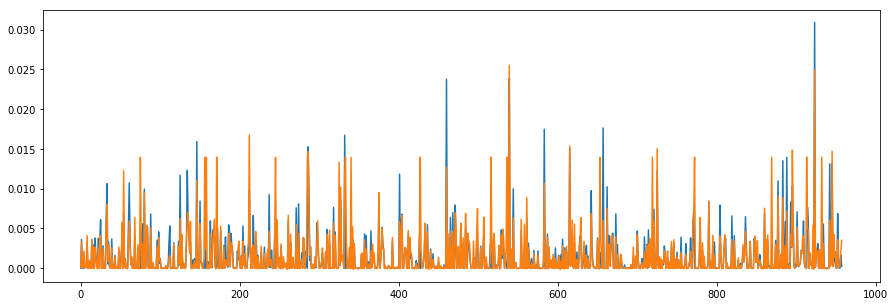

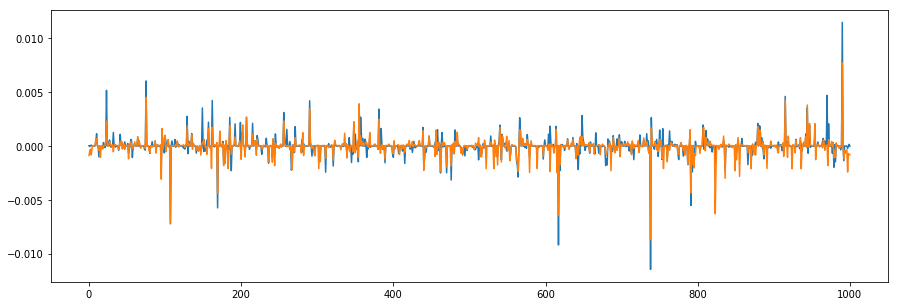

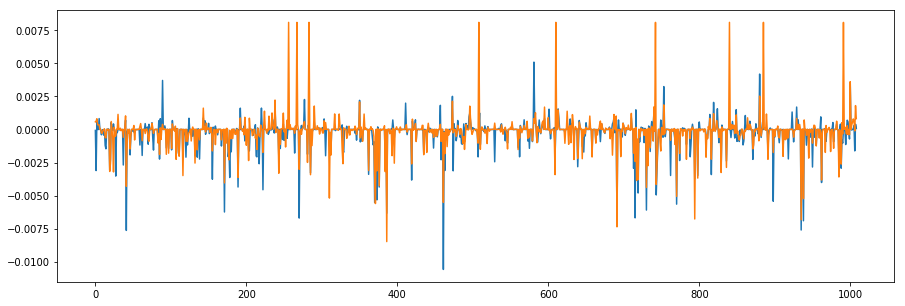

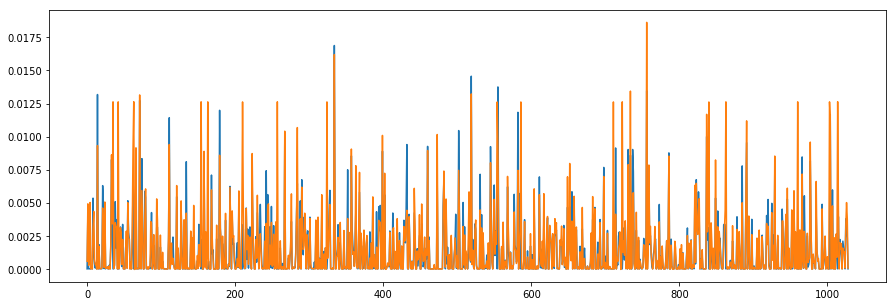

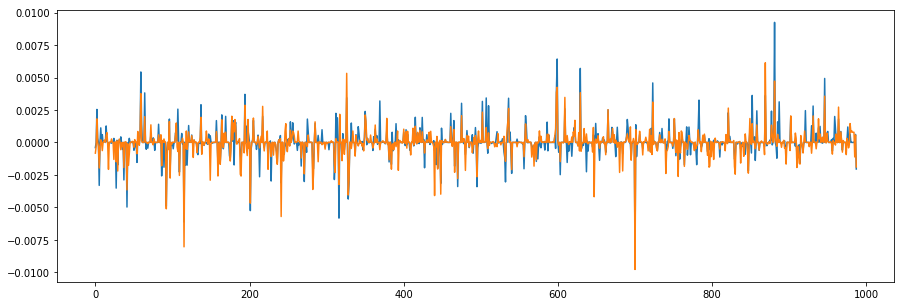

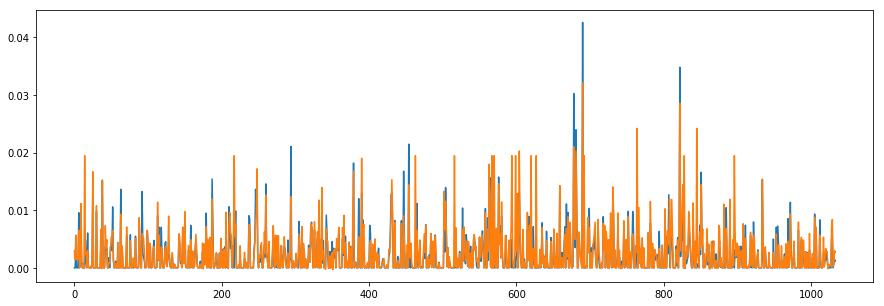

AttributeError: 'list' object has no attribute 'to_json'

In [60]:
prefix = ''
#model_nn_1_3, results_nn_1_3 = main('one-layer NN', 1, None, 3, prefix)
#model_nn_2_3, results_nn_2_3 = main('two-layer NN', 1, None, 3, prefix)
#model_conv_3d_3, results_conv_3d_3 = main('conv-3d NN', 3, None, 3, prefix)
#model_nn_1_4, results_nn_1_4 = main('one-layer NN', 1, None, 4, prefix)
#model_nn_2_4, results_nn_2_4 = main('two-layer NN', 1, None, 4, prefix)
#model_conv_3d_4, results_conv_3d_4 = main('conv-3d NN', 3, None, 4, prefix)
#model_nn_1_5, results_nn_1_5 = main('one-layer NN', 1, None, 5, prefix)
#model_nn_2_5, results_nn_2_5 = main('two-layer NN', 1, None, 5, prefix)
#model_conv_3d_5, results_conv_3d_5 = main('conv-3d NN', 3, None, 5, prefix)
#model_nn_1_6, results_nn_1_6 = main('one-layer NN', 1, None, 6, prefix)
#model_nn_2_6, results_nn_2_6 = main('two-layer NN', 1, None, 6, prefix)
#model_conv_3d_6, results_conv_3d_6 = main('conv-3d NN', 3, None, 6, prefix)

#model_conv_3d_feng, results_conv_3d_feng = main_feng('conv-3d NN Feng', 3, None, 6, prefix)

prefix = 'Re15sh20_DNScoarse8/'
model_conv_3d_base, results_conv_3d_base = main('conv-3d NN', 3, None, 3, prefix, 1.0)

# serialize model to JSON
model_json = model_conv_3d_base.to_json()
with open("model_conv_3d_base.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_conv_3d_base.save_weights("model_conv_3d_base.h5")
print("Saved model to disk")

Shape of Input Files:
(146, 96, 75)
(148, 98, 77)
(array([  1,   1,   1, ..., 146, 146, 146]), array([ 1,  1,  1, ..., 96, 96, 96]), array([ 1,  2,  3, ..., 54, 55, 56]))
X_train shape (784896, 3, 3, 3, 6)
tau_train shape (784896, 1)
784896 train samples
1051200 test samples
(73, 48, 38)
(array([ 1,  1,  1, ..., 71, 71, 71]), array([ 1,  1,  1, ..., 46, 46, 46]), array([ 1,  2,  3, ..., 25, 26, 27]))
X_train shape (88182, 3, 3, 3, 6)
tau_train shape (88182, 1)
88182 train samples
117576 test samples
(48, 32, 25)
(array([ 1,  1,  1, ..., 46, 46, 46]), array([ 1,  1,  1, ..., 30, 30, 30]), array([ 1,  2,  3, ..., 15, 16, 17]))
X_train shape (23460, 3, 3, 3, 6)
tau_train shape (23460, 1)
23460 train samples
31740 test samples
(896538, 3, 3, 3, 6)
(1200516, 3, 3, 3, 6)












_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_35 (Conv3D)           (None, 1, 1, 1, 128)      10496     
______________

Train on 896538 samples, validate on 896538 samples
Epoch 1/20
896538/896538 [==============================] - 569s 635us/step - loss: 0.3805 - mean_squared_error: 0.3805 - val_loss: 0.3075 - val_mean_squared_error: 0.3075
Epoch 2/20
896538/896538 [==============================] - 547s 610us/step - loss: 0.2898 - mean_squared_error: 0.2898 - val_loss: 0.2759 - val_mean_squared_error: 0.2759
Epoch 3/20
896538/896538 [==============================] - 645s 719us/step - loss: 0.2673 - mean_squared_error: 0.2673 - val_loss: 0.2598 - val_mean_squared_error: 0.2598
Epoch 4/20
896538/896538 [==============================] - 700s 781us/step - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2471 - val_mean_squared_error: 0.2471
Epoch 5/20
896538/896538 [==============================] - 550s 613us/step - loss: 0.2425 - mean_squared_error: 0.2425 - val_loss: 0.2362 - val_mean_squared_error: 0.2362
Epoch 6/20
896538/896538 [==============================] - 548s 611us/step - loss: 0.23

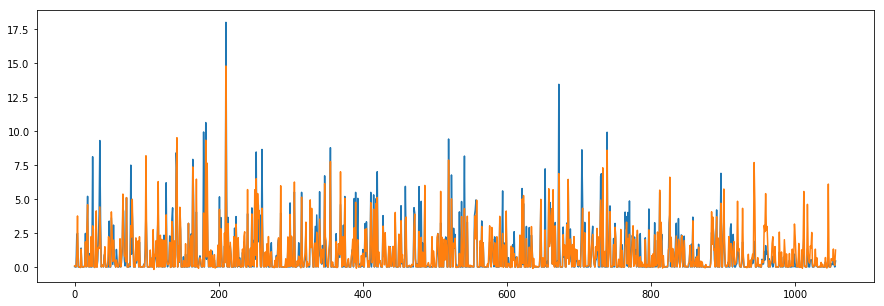

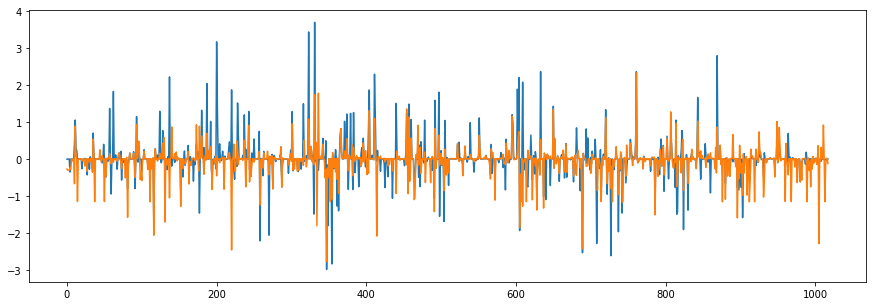

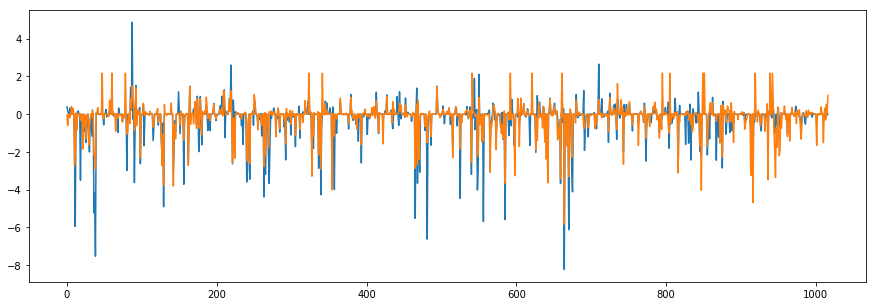

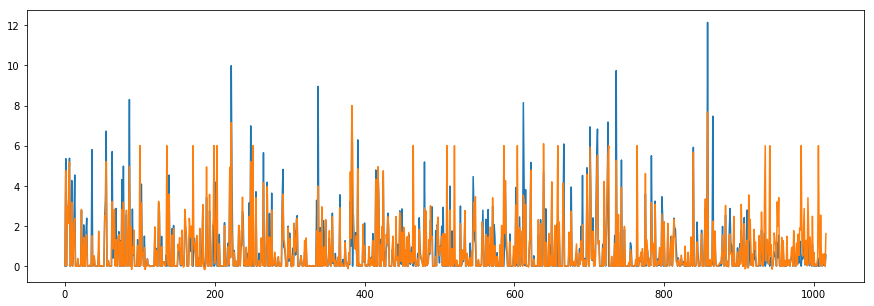

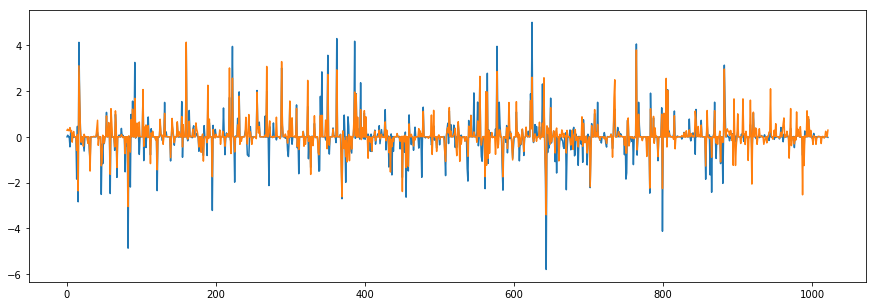

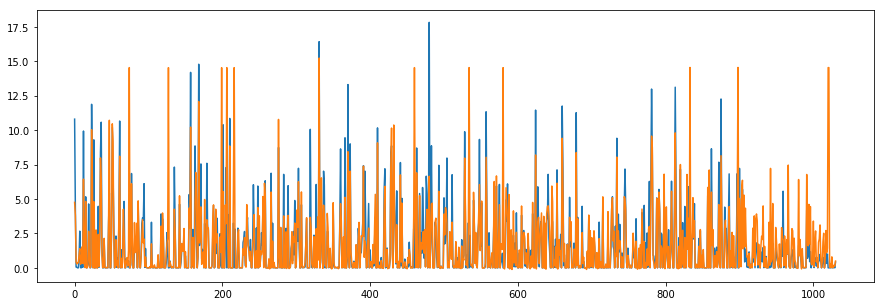

In [93]:
prefix = ''
#model_nn_1_3, results_nn_1_3 = main('one-layer NN', 1, None, 3, prefix)
#model_nn_2_3, results_nn_2_3 = main('two-layer NN', 1, None, 3, prefix)
#model_conv_3d_3, results_conv_3d_3 = main('conv-3d NN', 3, None, 3, prefix)
#model_nn_1_4, results_nn_1_4 = main('one-layer NN', 1, None, 4, prefix)
#model_nn_2_4, results_nn_2_4 = main('two-layer NN', 1, None, 4, prefix)
#model_conv_3d_4, results_conv_3d_4 = main('conv-3d NN', 3, None, 4, prefix)
#model_nn_1_5, results_nn_1_5 = main('one-layer NN', 1, None, 5, prefix)
#model_nn_2_5, results_nn_2_5 = main('two-layer NN', 1, None, 5, prefix)
#model_conv_3d_5, results_conv_3d_5 = main('conv-3d NN', 3, None, 5, prefix)
#model_nn_1_6, results_nn_1_6 = main('one-layer NN', 1, None, 6, prefix)
#model_nn_2_6, results_nn_2_6 = main('two-layer NN', 1, None, 6, prefix)
#model_conv_3d_6, results_conv_3d_6 = main('conv-3d NN', 3, None, 6, prefix)

#model_conv_3d_feng, results_conv_3d_feng = main_feng('conv-3d NN Feng', 3, None, 6, prefix)

#prefix = 'Re15sh20_DNScoarse8/'
#model_conv_3d_base, results_conv_3d_base = main('conv-3d NN', 3, None, 3, prefix, 1.0)

# serialize model to JSON
#model_json = model_conv_3d_base.to_json()
#with open("model_conv_3d_base.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model_conv_3d_base.save_weights("model_conv_3d_base.h5")
#print("Saved model to disk")

#prefix = 'Re15sh5_DNScoarse8/'
#model_conv_3d_base_5, results_conv_3d_base_5 = main('conv-3d NN', 3, None, 3, prefix, 1.0)
(model_conv_3d_division, results_conv_3d_division, 
mu_11, mu_12, mu_13, mu_22, mu_23, mu_33,
std_11, std_12, std_13, std_22, std_23, std_33) = main_multiple('conv-3d NN Combined', 3, None, 3, '', 1.0)

In [111]:
results = [predict_multiple(model_conv_3d_division[0], x_test[...,:xdim], tau_11_test, mu_11, std_11, delta),
           predict_multiple(model_conv_3d_division[1], x_test[...,:xdim], tau_12_test, mu_12, std_12, delta),
           predict_multiple(model_conv_3d_division[2], x_test[...,:xdim], tau_13_test, mu_13, std_13, delta),
           predict_multiple(model_conv_3d_division[3], x_test[...,:xdim], tau_22_test, mu_22, std_22, delta),
           predict_multiple(model_conv_3d_division[4], x_test[...,:xdim], tau_23_test, mu_23, std_23, delta),
           predict_multiple(model_conv_3d_division[5], x_test[...,:xdim], tau_33_test, mu_33, std_33, delta)]

In [116]:
results

[(array([[1.        , 0.65815517],
         [0.65815517, 1.        ]]), 0.0035780096345631326),
 (array([[1.        , 0.44049513],
         [0.44049513, 1.        ]]), 0.0012115068997810335),
 (array([[1.        , 0.54598563],
         [0.54598563, 1.        ]]), 0.0019172462646161981),
 (array([[1.        , 0.51788362],
         [0.51788362, 1.        ]]), 0.003932333071557253),
 (array([[1.        , 0.61657325],
         [0.61657325, 1.        ]]), 0.0012372444212163333),
 (array([[1.        , 0.41471274],
         [0.41471274, 1.        ]]), 0.008966542963290022)]

In [115]:
results_conv_3d_multiple

[(array([[1.        , 0.54912288],
         [0.54912288, 1.        ]]), 0.0033106340690984525),
 (array([[1.        , 0.76776642],
         [0.76776642, 1.        ]]), 0.000577773008225532),
 (array([[1.        , 0.66560888],
         [0.66560888, 1.        ]]), 0.0012287142769715424),
 (array([[1.        , 0.82865598],
         [0.82865598, 1.        ]]), 0.0014202294337052898),
 (array([[1.        , 0.80068133],
         [0.80068133, 1.        ]]), 0.0007006002573423173),
 (array([[1.        , 0.79041394],
         [0.79041394, 1.        ]]), 0.002542694118680003)]

In [94]:
results_conv_3d_division

[(array([[1.        , 0.86160456],
         [0.86160456, 1.        ]]), 0.941352620056105),
 (array([[1.       , 0.6572681],
         [0.6572681, 1.       ]]), 0.4503894461142565),
 (array([[1.        , 0.72027857],
         [0.72027857, 1.        ]]), 0.6523820092672069),
 (array([[1.        , 0.77281228],
         [0.77281228, 1.        ]]), 1.004072107270457),
 (array([[1.        , 0.78797572],
         [0.78797572, 1.        ]]), 0.46598165041312967),
 (array([[1.        , 0.66217172],
         [0.66217172, 1.        ]]), 2.1303519885410704)]

In [117]:
results

[(array([[1.        , 0.65815517],
         [0.65815517, 1.        ]]), 0.0035780096345631326),
 (array([[1.        , 0.44049513],
         [0.44049513, 1.        ]]), 0.0012115068997810335),
 (array([[1.        , 0.54598563],
         [0.54598563, 1.        ]]), 0.0019172462646161981),
 (array([[1.        , 0.51788362],
         [0.51788362, 1.        ]]), 0.003932333071557253),
 (array([[1.        , 0.61657325],
         [0.61657325, 1.        ]]), 0.0012372444212163333),
 (array([[1.        , 0.41471274],
         [0.41471274, 1.        ]]), 0.008966542963290022)]

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(526109, 5)
(525091, 5)



526109 train samples
525091 test samples
(526109, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_555 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_556 (Dense)            (None, 1)                 11        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Train on 526109 samples, validate on 525091 samples
Epoch 1/20
526109/526109 [==============================] - 9s 17us/step - loss: 1.0570 - mean_squared_error: 1.0570 - val_loss: 0.9843 - val_mean_squared_error: 0.9843
Epoch 2/20
526109/526109 [==============================] - 5s 9us/step - loss: 0.9

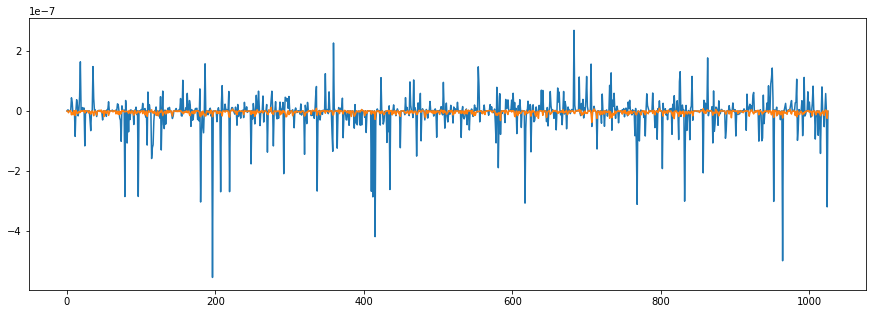

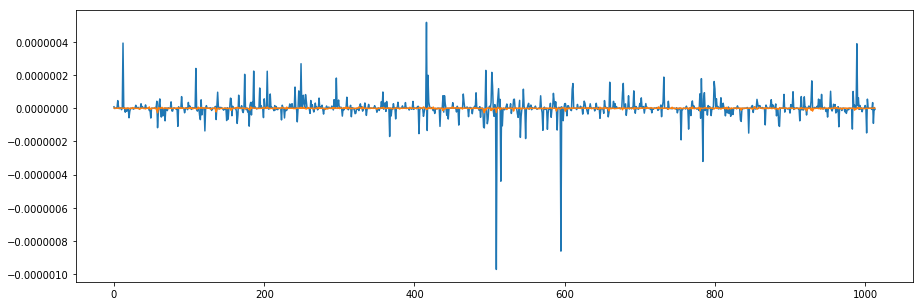

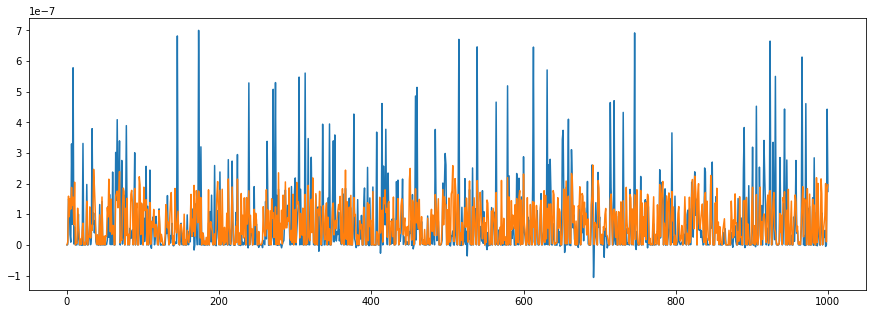

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(526133, 5)
(525067, 5)



526133 train samples
525067 test samples
(526133, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_561 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_562 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_563 (Dense)            (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Train on 526133 samples, validate on 525067 samples
Epoch 1/20
526133/526133 [==============================] - 10s 19us/step - loss: 1.0140 - mean_squared_error: 1.0140 

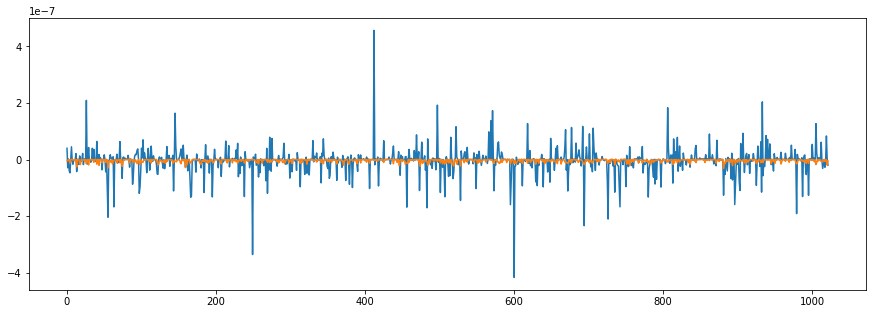

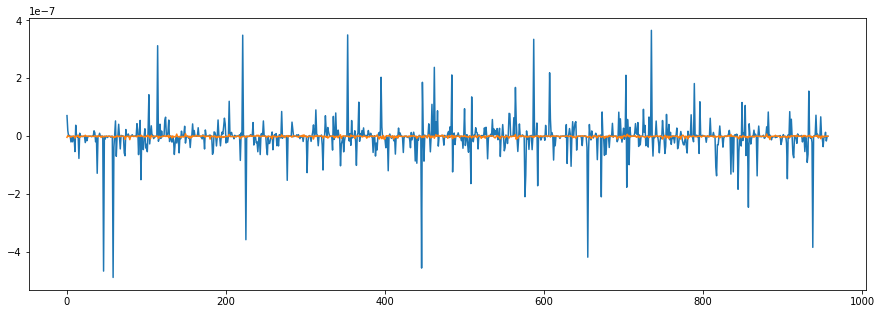

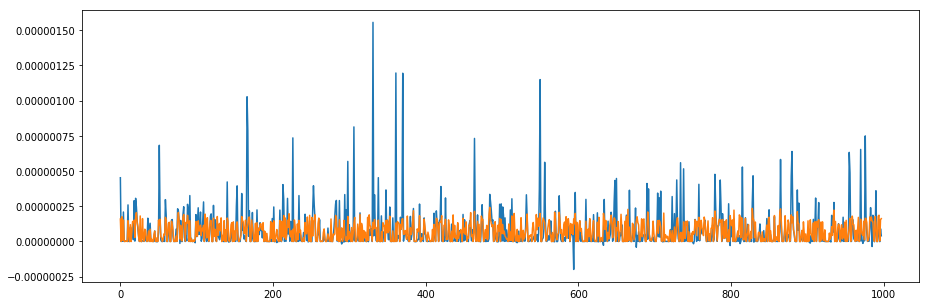

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))



(494064, 3, 3, 3, 5)





X_train shape (494064, 3, 3, 3, 5)
tau_train shape (494064, 1)
494064 train samples
494064 test samples
(494064, 3, 3, 3, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_87 (Conv3D)           (None, 1, 1, 1, 128)      10496     
_________________________________________________________________
activation_87 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_87 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_570 (Dense)            (None, 16)                2064      
______________________

Epoch 14/20
494064/494064 [==============================] - 303s 613us/step - loss: 0.5910 - mean_squared_error: 0.5910 - val_loss: 0.7094 - val_mean_squared_error: 0.7094
Epoch 15/20
494064/494064 [==============================] - 304s 614us/step - loss: 0.5856 - mean_squared_error: 0.5856 - val_loss: 0.6966 - val_mean_squared_error: 0.6966
Epoch 16/20
494064/494064 [==============================] - 306s 619us/step - loss: 0.5824 - mean_squared_error: 0.5824 - val_loss: 0.7025 - val_mean_squared_error: 0.7025
Epoch 17/20
494064/494064 [==============================] - 303s 614us/step - loss: 0.5777 - mean_squared_error: 0.5777 - val_loss: 0.6960 - val_mean_squared_error: 0.6960
Epoch 18/20
494064/494064 [==============================] - 304s 614us/step - loss: 0.5745 - mean_squared_error: 0.5745 - val_loss: 0.6837 - val_mean_squared_error: 0.6837
Epoch 19/20
494064/494064 [==============================] - 303s 614us/step - loss: 0.5708 - mean_squared_error: 0.5708 - val_loss: 0.

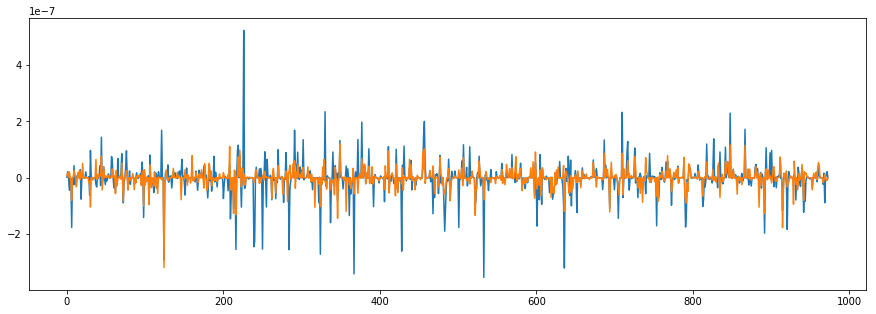

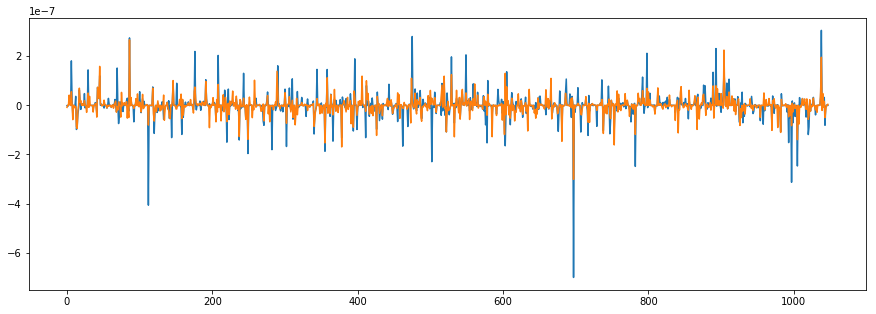

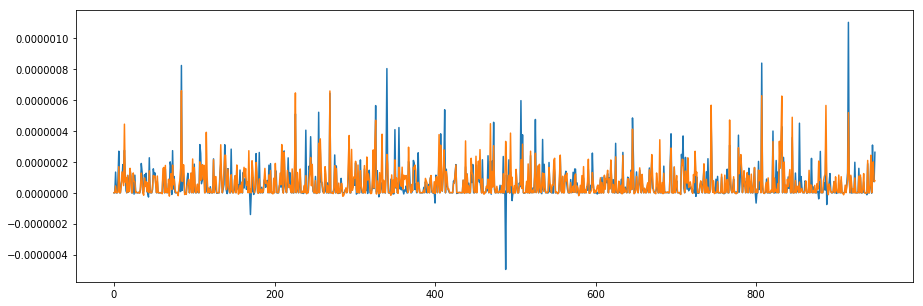

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(525226, 5)
(525974, 5)



525226 train samples
525974 test samples
(525226, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_576 (Dense)            (None, 10)                50        
_________________________________________________________________
dense_577 (Dense)            (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Train on 525226 samples, validate on 525974 samples
Epoch 1/20
525226/525226 [==============================] - 9s 16us/step - loss: 1.0407 - mean_squared_error: 1.0407 - val_loss: 0.9997 - val_mean_squared_error: 0.9997
Epoch 2/20
525226/525226 [==============================] - 3s 6us/step - loss: 0.9

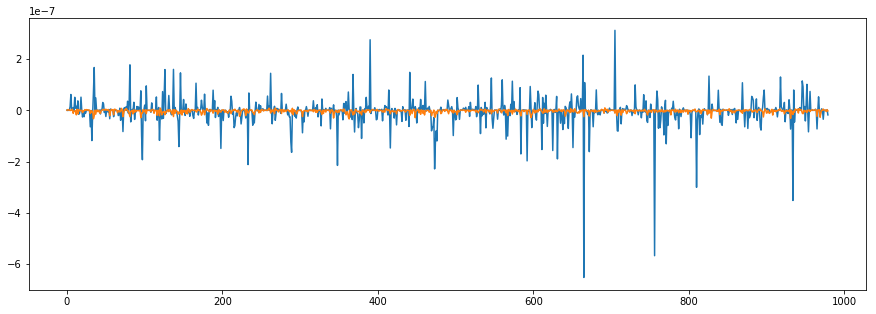

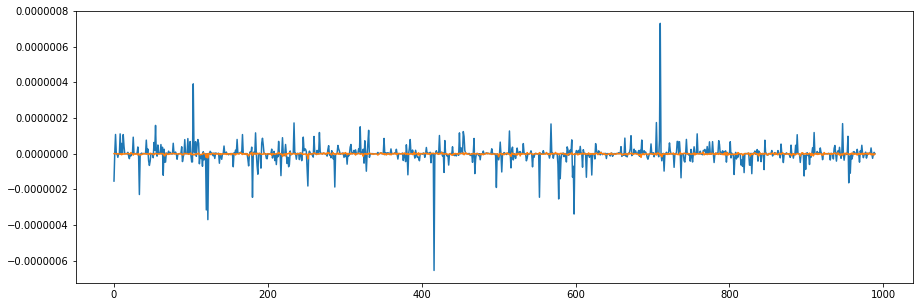

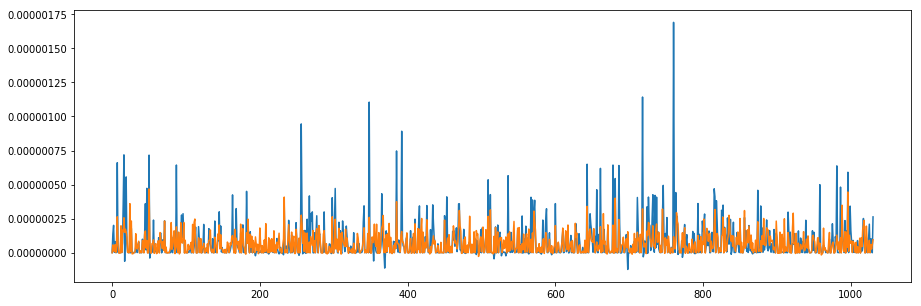

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(525340, 5)
(525860, 5)



525340 train samples
525860 test samples
(525340, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_582 (Dense)            (None, 10)                50        
_________________________________________________________________
dense_583 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_584 (Dense)            (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Train on 525340 samples, validate on 525860 samples
Epoch 1/20
525340/525340 [==============================] - 9s 17us/step - loss: 1.0128 - mean_squared_error: 1.0128 -

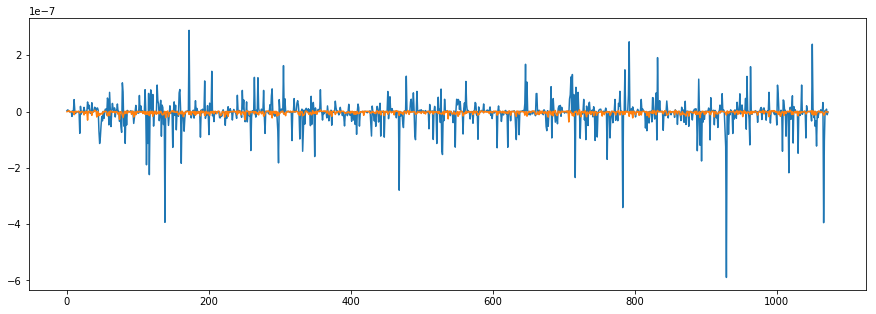

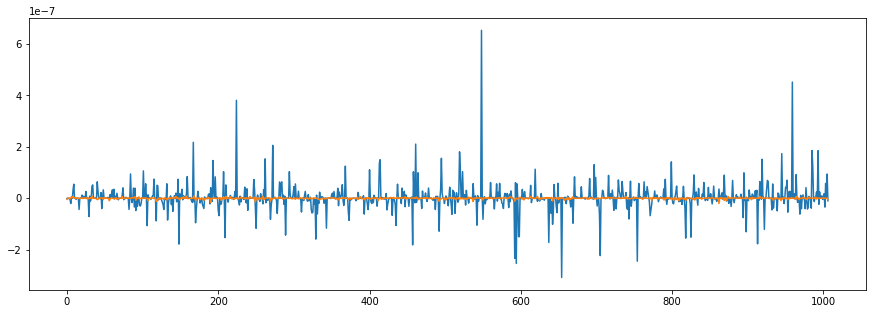

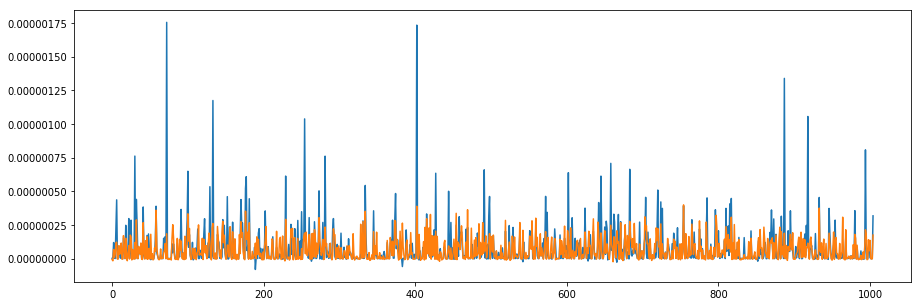

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))



(494064, 3, 3, 3, 5)





X_train shape (494064, 3, 3, 3, 5)
tau_train shape (494064, 1)
494064 train samples
494064 test samples
(494064, 3, 3, 3, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_90 (Conv3D)           (None, 1, 1, 1, 128)      13952     
_________________________________________________________________
activation_90 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_90 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_591 (Dense)            (None, 16)                2064      
______________________

Epoch 14/20
494064/494064 [==============================] - 306s 619us/step - loss: 0.5444 - mean_squared_error: 0.5444 - val_loss: 0.6268 - val_mean_squared_error: 0.6268
Epoch 15/20
494064/494064 [==============================] - 305s 617us/step - loss: 0.5402 - mean_squared_error: 0.5402 - val_loss: 0.6342 - val_mean_squared_error: 0.6342
Epoch 16/20
494064/494064 [==============================] - 306s 619us/step - loss: 0.5309 - mean_squared_error: 0.5309 - val_loss: 0.6947 - val_mean_squared_error: 0.6947
Epoch 17/20
494064/494064 [==============================] - 305s 618us/step - loss: 0.5253 - mean_squared_error: 0.5253 - val_loss: 0.6675 - val_mean_squared_error: 0.6675
Epoch 18/20
494064/494064 [==============================] - 306s 619us/step - loss: 0.5161 - mean_squared_error: 0.5161 - val_loss: 0.6121 - val_mean_squared_error: 0.6121
Epoch 19/20
494064/494064 [==============================] - 306s 619us/step - loss: 0.5120 - mean_squared_error: 0.5120 - val_loss: 0.

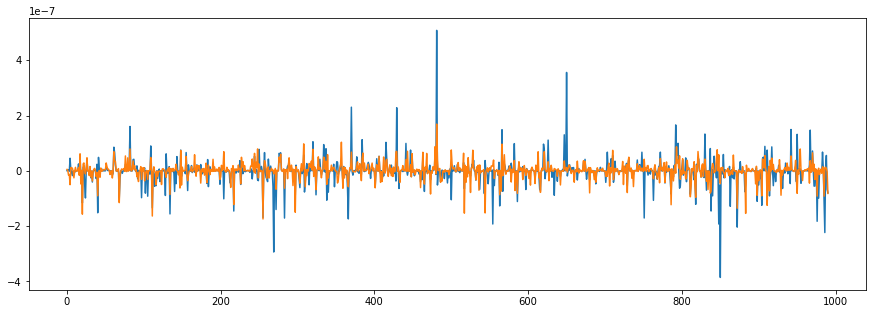

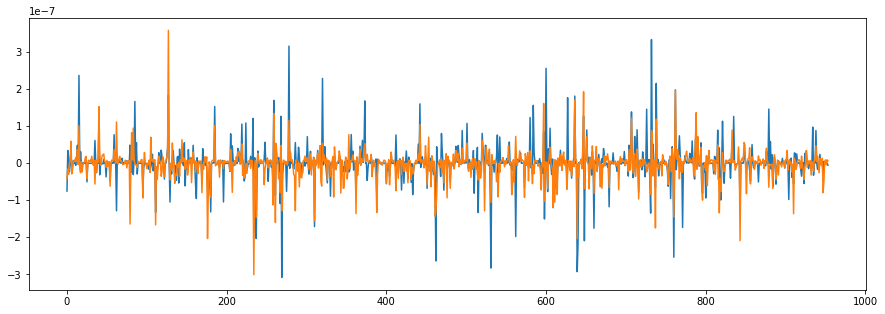

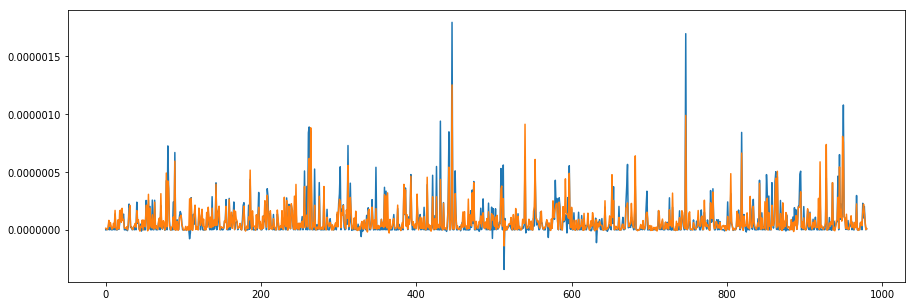

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(526002, 5)
(525198, 5)



526002 train samples
525198 test samples
(526002, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_597 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_598 (Dense)            (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
Train on 526002 samples, validate on 525198 samples
Epoch 1/20
526002/526002 [==============================] - 9s 17us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 0.9718 - val_mean_squared_error: 0.9718
Epoch 2/20
526002/526002 [==============================] - 4s 7us/step - loss: 0.9

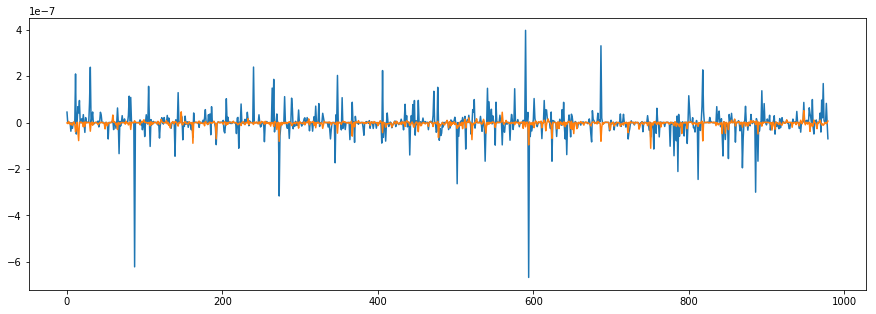

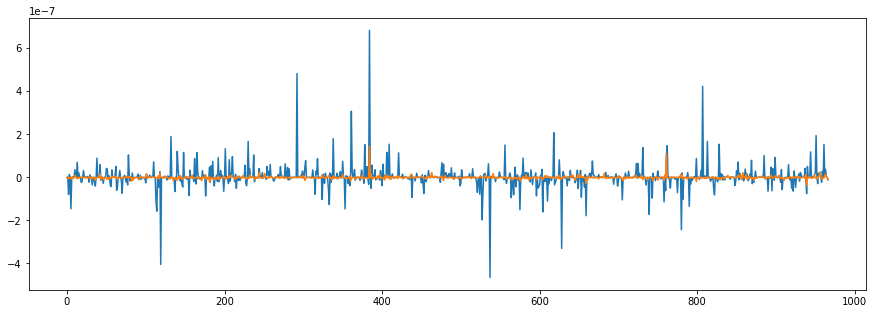

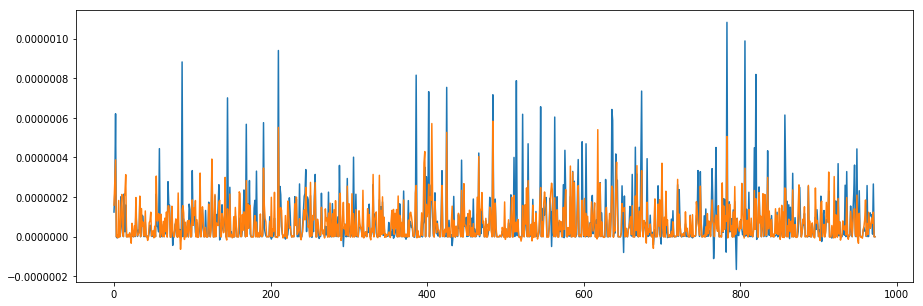

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(525538, 5)
(525662, 5)



525538 train samples
525662 test samples
(525538, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_603 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_604 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_605 (Dense)            (None, 1)                 11        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Train on 525538 samples, validate on 525662 samples
Epoch 1/20
525538/525538 [==============================] - 9s 17us/step - loss: 0.9951 - mean_squared_error: 0.9951 -

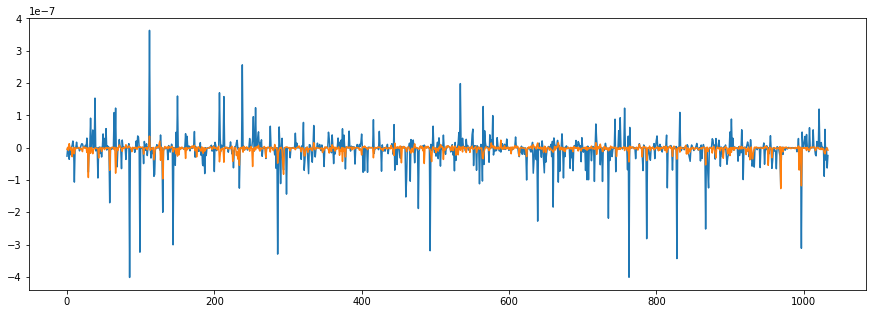

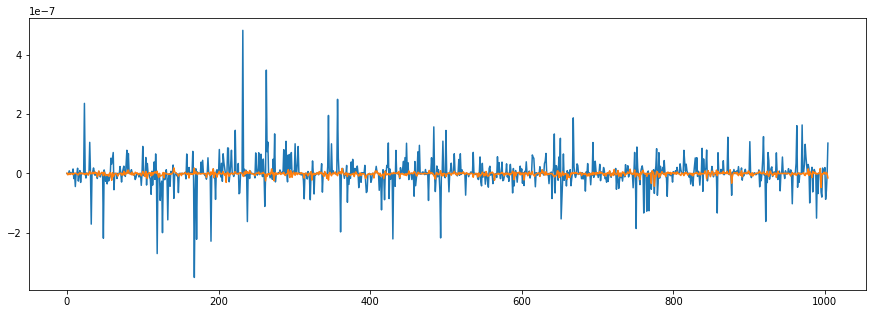

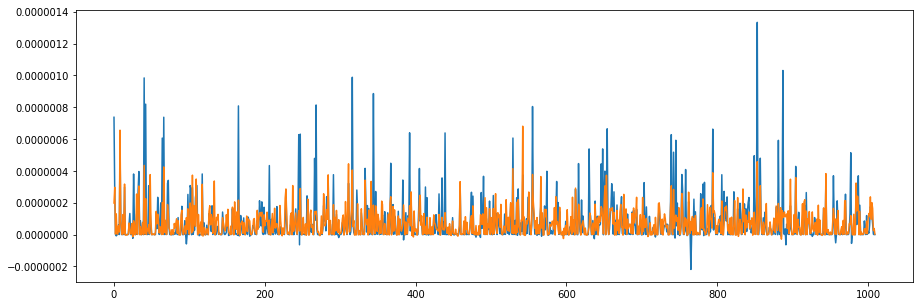

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))



(494064, 3, 3, 3, 5)





X_train shape (494064, 3, 3, 3, 5)
tau_train shape (494064, 1)
494064 train samples
494064 test samples
(494064, 3, 3, 3, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_93 (Conv3D)           (None, 1, 1, 1, 128)      17408     
_________________________________________________________________
activation_93 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_93 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_612 (Dense)            (None, 16)                2064      
______________________

Epoch 14/20
494064/494064 [==============================] - 319s 647us/step - loss: 0.4409 - mean_squared_error: 0.4409 - val_loss: 0.5523 - val_mean_squared_error: 0.5523
Epoch 15/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.4318 - mean_squared_error: 0.4318 - val_loss: 0.5621 - val_mean_squared_error: 0.5621
Epoch 16/20
494064/494064 [==============================] - 307s 622us/step - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.6393 - val_mean_squared_error: 0.6393
Epoch 17/20
494064/494064 [==============================] - 307s 621us/step - loss: 0.4163 - mean_squared_error: 0.4163 - val_loss: 0.5295 - val_mean_squared_error: 0.5295
Epoch 18/20
494064/494064 [==============================] - 307s 621us/step - loss: 0.4117 - mean_squared_error: 0.4117 - val_loss: 0.5060 - val_mean_squared_error: 0.5060
Epoch 19/20
494064/494064 [==============================] - 307s 621us/step - loss: 0.4032 - mean_squared_error: 0.4032 - val_loss: 0.

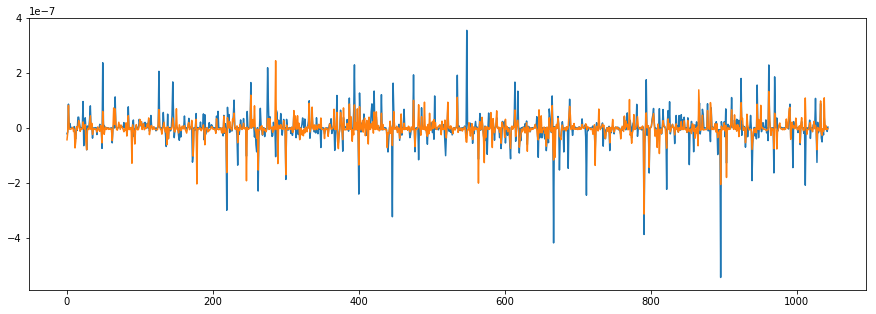

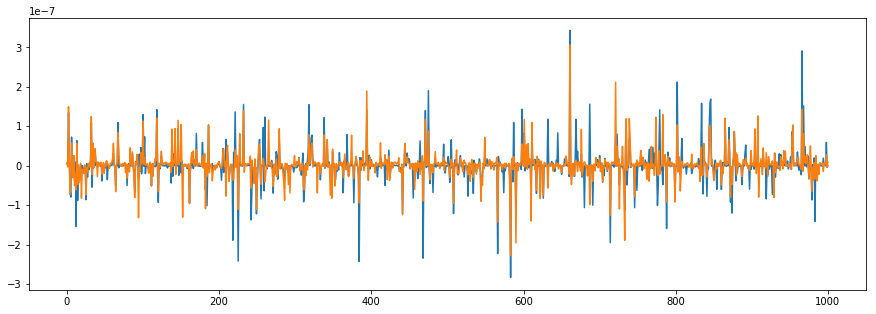

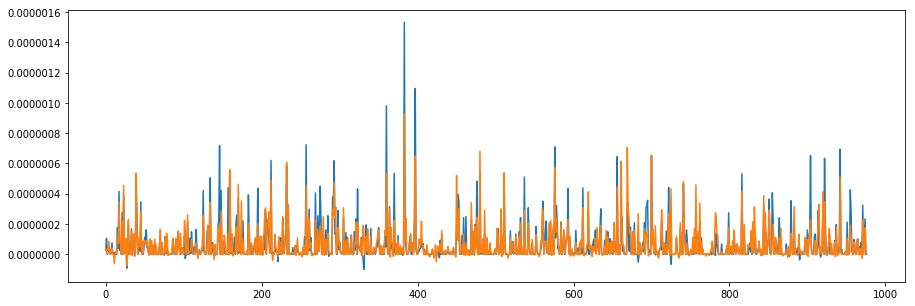

In [490]:
model_nn_1_3_heat, results_nn_1_3_heat = main_heat('one-layer NN', 1, None, 3, prefix)
model_nn_2_3_heat, results_nn_2_3_heat = main_heat('two-layer NN', 1, None, 3, prefix)
model_conv_3d_3_heat, results_conv_3d_3_heat = main_heat('conv-3d NN', 3, None, 3, prefix)
model_nn_1_4_heat, results_nn_1_4_heat = main_heat('one-layer NN', 1, None, 4, prefix)
model_nn_2_4_heat, results_nn_2_4_heat = main_heat('two-layer NN', 1, None, 4, prefix)
model_conv_3d_4_heat, results_conv_3d_4_heat = main_heat('conv-3d NN', 3, None, 4, prefix)
model_nn_1_5_heat, results_nn_1_5_heat = main_heat('one-layer NN', 1, None, 5, prefix)
model_nn_2_5_heat, results_nn_2_5_heat = main_heat('two-layer NN', 1, None, 5, prefix)
model_conv_3d_5_heat, results_conv_3d_5_heat = main_heat('conv-3d NN', 3, None, 5, prefix)

In [242]:
results_nn_1_heat

[(array([[1.        , 0.22214517],
         [0.22214517, 1.        ]]), 5.423537704583692e-08),
 (array([[1.       , 0.1326358],
         [0.1326358, 1.       ]]), 5.4933549917546137e-08),
 (array([[1.        , 0.65760738],
         [0.65760738, 1.        ]]), 1.0036455536678398e-07)]

In [243]:
results_nn_2_heat

[(array([[1.        , 0.22925952],
         [0.22925952, 1.        ]]), 5.431780828535776e-08),
 (array([[1.        , 0.13592313],
         [0.13592313, 1.        ]]), 5.4546890420478587e-08),
 (array([[1.        , 0.66339873],
         [0.66339873, 1.        ]]), 1.0057676774645586e-07)]

In [501]:
results_conv_3d_5_heat

[(array([[1.        , 0.69559997],
         [0.69559997, 1.        ]]), 3.696457513589673e-08),
 (array([[1.        , 0.73423981],
         [0.73423981, 1.        ]]), 3.588262758393648e-08),
 (array([[1.        , 0.84400906],
         [0.84400906, 1.        ]]), 6.811240242195158e-08)]

In [348]:
results_conv_3d_aug_heatew

[(array([[1.        , 0.68823515],
         [0.68823515, 1.        ]]), 3.7446852184809874e-08),
 (array([[1.        , 0.73370279],
         [0.73370279, 1.        ]]), 3.596192548974636e-08),
 (array([[1.        , 0.86261711],
         [0.86261711, 1.        ]]), 6.422930993686968e-08)]

In [349]:
results_conv_3d_aug_reflect_heat

[(array([[1.        , 0.66685282],
         [0.66685282, 1.        ]]), 3.838655199579966e-08),
 (array([[1.        , 0.72289363],
         [0.72289363, 1.        ]]), 3.646564192437506e-08),
 (array([[1.       , 0.8630161],
         [0.8630161, 1.       ]]), 6.414254666207523e-08)]

## Visualizations

In [28]:
# Output Data
model_name, size, augmentation, xdim,  prefix = 'conv-3d NN', 3, None, 3, 'Re15sh20_DNScoarse8/'

tau_11, tau_12, tau_13, tau_22, tau_23, tau_33 = get_output_data(prefix)
print('Shape of Output Files:')
print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)

# Input Data
uf, vf, wf, tke, theta, grad = get_input_data(prefix)
print('Shape of Input Files:')
print(wf.shape)
    
# Explore Data
#explore_data(tau_12)

# Get Functions
train_test_split_func, model_func = models[model_name]

# Reshape Data and Get Train/Test Sets
(_, _, _, _, 
 _, _, _, _,
 _, _, _, _, _, _,
 mu_11, std_11, mu_12, std_12, mu_13, std_13, 
 mu_22, std_22, mu_23, std_23, mu_33, std_33) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                   tau_33, uf, vf, wf, tke, theta, grad,
                                                                      train_pct = 0.5, size = size,
                                                                     augmentation = augmentation)

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 77)
(array([  1,   1,   1, ..., 144, 144, 144]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 52, 53, 54]))












X_train shape (730944, 3, 3, 3, 6)
tau_train shape (730944, 1)
730944 train samples
988128 test samples


In [41]:
# Output Data
model_name, size, augmentation, xdim,  prefix = 'conv-3d NN', 3, None, 3, 'Re15sh20_DNScoarse8/'

tau_11, tau_12, tau_13, tau_22, tau_23, tau_33 = get_output_data(prefix)
print('Shape of Output Files:')
print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)

# Input Data
uf, vf, wf, tke, theta, grad = get_input_data(prefix)
print('Shape of Input Files:')
print(wf.shape)
    
# Explore Data
#explore_data(tau_12)

# Get Functions
train_test_split_func, model_func = models[model_name]

# Reshape Data and Get Train/Test Sets
(x_train, x_test, tau_11_train, tau_11_test, 
 tau_12_train, tau_12_test, tau_13_train, tau_13_test,
 tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
 _, _, _, _, _, _, 
 _, _, _, _, _, _) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                   tau_33, uf, vf, wf, tke, theta, grad,
                                                                      train_pct = 0.5, size = size,
                                                                     augmentation = augmentation)

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([  1,   1,   1, ..., 144, 144, 144]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))












X_train shape (988128, 3, 3, 3, 6)
tau_train shape (988128, 1)
988128 train samples
988128 test samples


In [42]:
y_test, model, mu, std = tau_11_test, model_conv_3d_base[0], mu_11, std_11

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_12_test, model_conv_3d_base[1], mu_12, std_12

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_13_test, model_conv_3d_base[2], mu_13, std_13

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_22_test, model_conv_3d_base[3], mu_22, std_22

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_23_test, model_conv_3d_base[4], mu_23, std_23

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_33_test, model_conv_3d_base[5], mu_33, std_33

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

[[1.         0.92687253]
 [0.92687253 1.        ]]
[[1.         0.83804204]
 [0.83804204 1.        ]]
[[1.         0.85862498]
 [0.85862498 1.        ]]
[[1.         0.93648298]
 [0.93648298 1.        ]]
[[1.         0.84672239]
 [0.84672239 1.        ]]
[[1.        0.9247355]
 [0.9247355 1.       ]]


In [678]:
len(y_test)

25872

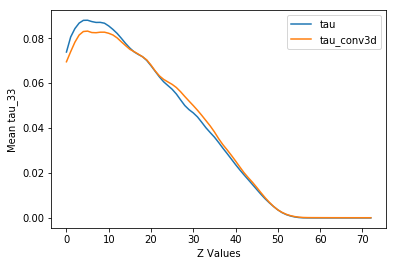

In [524]:
y_test, model, mu, std = tau_33_test, model_conv_3d_base[0], mu_33, std_33

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

y_test_final = y_test.reshape((72, 94, 73))
y_predict_final = y_predict.reshape((72, 94, 73))

y_test_z_mean = np.mean(y_test_final, axis = (0,1))
y_predict_z_mean = np.mean(y_predict_final, axis = (0,1))

plt.plot(range(73), y_test_z_mean)
plt.plot(range(73), y_predict_z_mean)
plt.legend(['tau','tau_conv3d'])
plt.xlabel('Z Values')
plt.ylabel('Mean tau_33')
plt.show()

In [545]:
y_test, model, mu, std = tau_23_test, model_conv_3d_3[4], mu_23, std_23

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

y_test_final = y_test.reshape((72, 94, 73))
y_predict_final = y_predict.reshape((72, 94, 73))

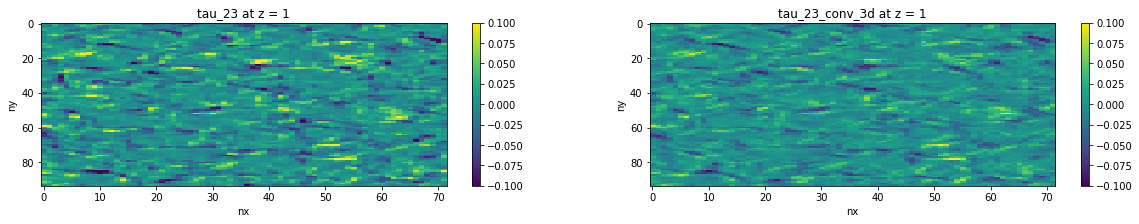

In [546]:
plt.figure(1, figsize = (20,3))
plt.subplot(121)
plt.imshow(np.transpose(y_test_final[:,:,1]), vmin=-0.1, vmax=0.1, aspect = 'auto')
plt.title('tau_23 at z = 1')
plt.xlabel('nx')
plt.ylabel('ny')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.transpose(y_predict_final[:,:,1]), vmin=-0.1, vmax=0.1, aspect = 'auto')
plt.colorbar()
plt.title('tau_23_conv_3d at z = 1')
plt.xlabel('nx')
plt.ylabel('ny')
plt.show()

In [34]:
loadmat(prefix + 'tau11_xyz_T1.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Oct 27 15:05:08 2018',
 '__version__': '1.0',
 '__globals__': [],
 'tau11_new': array([[[0.017208  , 0.02253444, 0.02348426, ..., 0.00522084,
          0.00665757, 0.0097664 ],
         [0.01343882, 0.01784584, 0.01910157, ..., 0.00807674,
          0.00920009, 0.01014834],
         [0.01225637, 0.01612121, 0.01708745, ..., 0.01107641,
          0.01348384, 0.01288878],
         ...,
         [0.01317266, 0.01436348, 0.01136994, ..., 0.01490796,
          0.01838596, 0.01967636],
         [0.0123603 , 0.01838575, 0.01935155, ..., 0.01048168,
          0.0107722 , 0.00907348],
         [0.00648122, 0.01193137, 0.01751257, ..., 0.00699863,
          0.005597  , 0.00519362]],
 
        [[0.01613575, 0.02096598, 0.02140606, ..., 0.00322224,
          0.00527737, 0.01002095],
         [0.01157449, 0.01791501, 0.020173  , ..., 0.00461354,
          0.0061113 , 0.00934311],
         [0.00878706, 0.01237559, 0.01520069, .